# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Import dependencies
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from citipy import citipy
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

# Grab API keys
from config import (api_key)

#Output to csv
output_data_file = "../output_data/weather.csv"

# Range of latitudes and longitudes
lat_r = (-90, 90)
lng_r = (-180, 180)

# set pass through count
count = 0
set1 = 1

###### Generate Cities List

In [2]:
LL = []
cities = []
countries = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)


# Identify nearest city for each lat, lng combination
for LL in zip(lats, lngs):
    city = citipy.nearest_city(LL[0], LL[1]).city_name
    country = citipy.nearest_city(LL[0], LL[1]).country_code
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country.upper())

# Print the city count to confirm sufficient count
print(len(cities))

#Print the country count to confirm it matches city count
print(len(countries))

615
615


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
#Create a dataframe to store the data
weatherdf = pd.DataFrame({'City': cities, 'Country': countries, 'Lat': "", 'Lng': "", 'Max Temp': "", 'Cloudiness': "",
                            'Humidity': "", 'Windspeed': "", 'Date': "",})

#Preview the dataframe
weatherdf.head()

,City,Country,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
0,bluff,NZ,,,,,,,
1,bengkulu,ID,,,,,,,
2,pevek,RU,,,,,,,
3,carnarvon,AU,,,,,,,
4,makakilo city,US,,,,,,,


In [4]:
# Variables to keep track of response number
record_n = 1
r_set = 1

#Add url
url = 'http://api.openweathermap.org/data/2.5/weather?units=imperial&q='

#API call each city
print('''
-----------------------------
Retrieving Data
-----------------------------''')
for index, row in weatherdf.iterrows(): 
    #Create the query url for the API call
    query_url = url + row['City'] + ',' + row['Country'] + '&APPID=' + api_key
    
    #API call
    response = requests.get(query_url).json()
    
    #Exception script in case the city is not found by the API call
    try: 
        #Meassage to alert the user that the data is being retrieved
        print(f'Processing Weather Data for Record {record_n} of Set {r_set} | {response["name"]}')
        
        #Input data into the dataframe
        weatherdf.loc[index, 'Cloudiness'] = response['clouds']['all']
        weatherdf.loc[index, 'Date'] = response['dt']
        weatherdf.loc[index, 'Humidity'] = response['main']['humidity']
        weatherdf.loc[index, 'Lat'] = response['coord']['lat']
        weatherdf.loc[index, 'Lng'] = response['coord']['lon']
        weatherdf.loc[index, 'Max Temp'] = response['main']['temp_max']
        weatherdf.loc[index, 'Windspeed'] = response['wind']['speed']
        
        #Increase the record count
        record_n += 1
        
    except (KeyError, IndexError):
        print("City not found, skipping.")
    
    #If statement to handle the API call limits
    if record_n == 51:
        r_set += 1
        record_n = 1
        time.sleep(1)
        
print('''
-----------------------------
Data Retrieval Complete
-----------------------------''')


-----------------------------
Retrieving Data
-----------------------------
Processing Weather Data for Record 1 of Set 1 | Bluff
Processing Weather Data for Record 2 of Set 1 | Bengkulu
Processing Weather Data for Record 3 of Set 1 | Pevek
Processing Weather Data for Record 4 of Set 1 | Carnarvon
Processing Weather Data for Record 5 of Set 1 | Makakilo City
Processing Weather Data for Record 6 of Set 1 | Tabas
Processing Weather Data for Record 7 of Set 1 | Tuktoyaktuk
Processing Weather Data for Record 8 of Set 1 | Butaritari
Processing Weather Data for Record 9 of Set 1 | Muhos
Processing Weather Data for Record 10 of Set 1 | Busselton
Processing Weather Data for Record 11 of Set 1 | Metro
Processing Weather Data for Record 12 of Set 1 | Sangar
Processing Weather Data for Record 13 of Set 1 | Kollam
Processing Weather Data for Record 14 of Set 1 | Georgetown
Processing Weather Data for Record 15 of Set 1 | Kijang
Processing Weather Data for Record 16 of Set 1 | Rikitea
Processing W

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# clean data to remove skipped cities
weatherdf['Max Temp'] = weatherdf['Max Temp'].replace("", np.nan)
weatherdf = weatherdf.dropna()
# Save to csv
weatherdf.to_csv(output_data_file, index=False)
weatherdf.head()


,City,Country,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
0,bluff,NZ,-46.6,168.3333,45.81,83,75,15.82,1627315253
1,bengkulu,ID,-3.8004,102.2655,75.16,64,76,4.29,1627315253
2,pevek,RU,69.7008,170.3133,35.38,81,89,12.15,1627315254
3,carnarvon,AU,-24.8667,113.6333,69.87,75,85,14.97,1627315010
4,makakilo city,US,21.3469,-158.0858,76.75,75,73,4.61,1627315009


In [6]:
df3 = pd.read_csv(output_data_file)
df3.dtypes

City           object
Country        object
Lat           float64
Lng           float64
Max Temp      float64
Cloudiness      int64
Humidity        int64
Windspeed     float64
Date            int64
dtype: object

In [7]:
df3.describe()

,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
count,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,5.490000e+02
mean,19.663909,18.130973,71.381056,56.765027,67.357013,8.656594,1.627315e+09
std,34.194711,91.732698,14.826140,37.571263,22.225291,6.113651,1.005445e+02
min,-54.800000,-179.166700,33.840000,0.000000,5.000000,0.000000,1.627315e+09
25%,-7.754300,-60.673300,59.950000,20.000000,56.000000,3.870000,1.627315e+09
50%,22.075200,18.593600,74.440000,67.000000,73.000000,7.540000,1.627315e+09
75%,49.486700,100.451700,81.840000,93.000000,84.000000,11.500000,1.627315e+09
max,78.218600,179.316700,115.770000,100.000000,100.000000,38.770000,1.627315e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,5.500000e+02
mean,19.973545,17.124400,58.331400,67.890909,52.141818,8.544800,1.585764e+09
std,33.284840,91.595451,25.795297,20.864881,35.766469,6.078869,5.539674e+01
min,-54.800000,-179.170000,-11.340000,9.000000,0.000000,0.160000,1.585764e+09
25%,-8.077500,-64.627500,42.800000,55.000000,20.000000,4.525000,1.585764e+09
50%,23.630000,19.635000,64.940000,72.000000,57.000000,7.325000,1.585764e+09
75%,48.672500,97.350000,78.800000,83.000000,86.750000,11.410000,1.585764e+09
max,78.220000,179.320000,102.200000,100.000000,100.000000,46.080000,1.585764e+09


In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

### Latitude vs. Temperature Plot

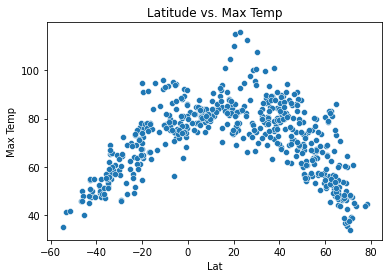

In [8]:
sns.scatterplot(data=df3, x="Lat", y="Max Temp").set_title(f'Latitude vs. Max Temp')
plt.savefig("../output_data/Fig1.png")
plt.show()

This Latitude vs. Max Temp scatterplot appears to a bell shape (normal distribution. This indiates that there is a strong negative relationship between moving away from the equator and max temp.

### Latitude vs. Humidity Plot

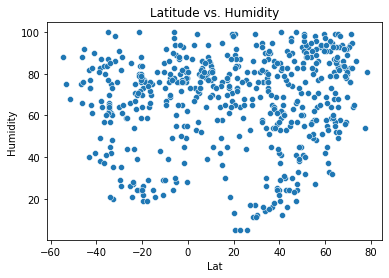

In [11]:
sns.scatterplot(data=df3, x="Lat", y="Humidity").set_title(f'Latitude vs. Humidity')
plt.savefig("../output_data/Fig2.png")
plt.show()

This Latitude vs. Humididty scatterplot appears to have a flat linear shape. This indicates no relationship between humidity and Latitude.

## Latitude vs. Cloudiness Plot

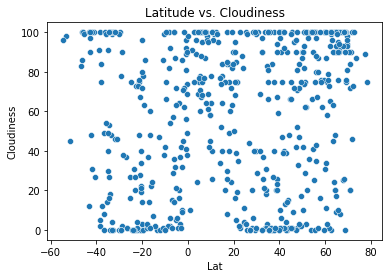

In [12]:
sns.scatterplot(data=df3, x="Lat", y="Cloudiness").set_title(f'Latitude vs. Cloudiness')
plt.savefig("../output_data/Fig3.png")
plt.show()

This Latitude vs. Cloudiness scatterplot appears to have a flat linear shape. This indicates no relationship between cloudiness and Latitude.

## Latitude vs. Wind Speed Plot

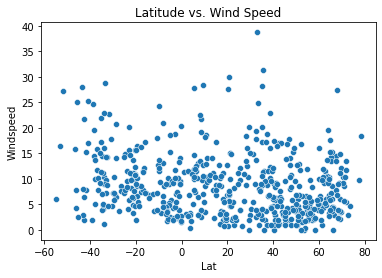

In [13]:
sns.scatterplot(data=df3, x="Lat", y="Windspeed").set_title(f'Latitude vs. Wind Speed')
plt.savefig("../output_data/Fig4.png")
plt.show()

This Latitude vs. Wind Speed scatterplot appears to have a flat linear shape. This indicates no relationship between wind speed and Latitude.

## Linear Regression

In [46]:
# Divide earth into north and south hemispheres
north = df3.loc[df3['Lat']>=0]
south = df3.loc[df3['Lat']<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

r=-0.693823488068576, p=5.448607143883121e-54


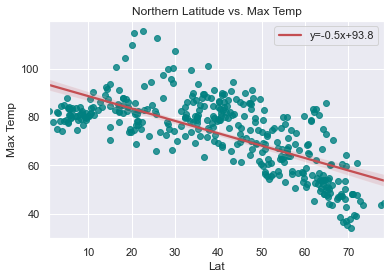

In [15]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Max Temp'])
ax = sns.regplot(x="Lat", y="Max Temp", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Max Temp')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

r=0.8206807297193638, p=1.2759846452077439e-45


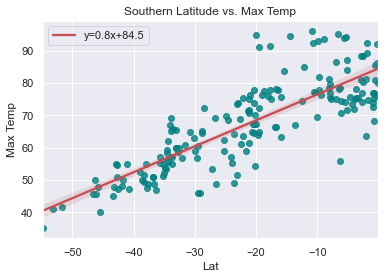

In [24]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Max Temp'])
ax = sns.regplot(x="Lat", y="Max Temp", data=south, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Max Temp')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

For both north and south hemispheres max temperatures decrease as locations move from the equator (0°). This suggests that there is an inverse relationship between polar latitude and max temperature.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

r=0.07349669182510944, p=0.15999397200394905


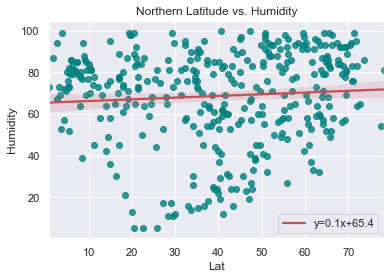

In [30]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Humidity'])
ax = sns.regplot(x="Lat", y="Humidity", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Humidity')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

r=0.018512955018224166, p=0.8040927082732382


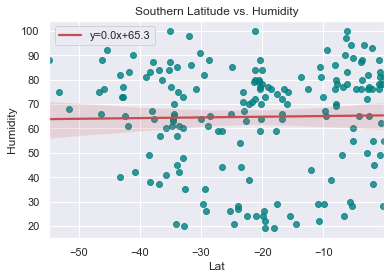

In [31]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Humidity'])
ax = sns.regplot(x="Lat", y="Humidity", data=south, 
                 color='r', scatter_kws={"color": "teal"},
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Humidity')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

For both north and south hemispheres there appears to little correlation between latitude and humidity. Regression plots for both hemispheres maintain an r value less than 0.1, indicating little to no relationship between the two variables.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

r=0.03500274716515986, p=0.5038313644304837


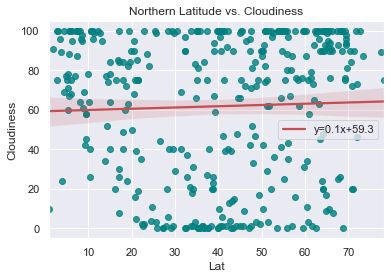

In [39]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Cloudiness'])
ax = sns.regplot(x="Lat", y="Cloudiness", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Cloudiness')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

r=-0.1478346456181249, p=0.04641341698529967


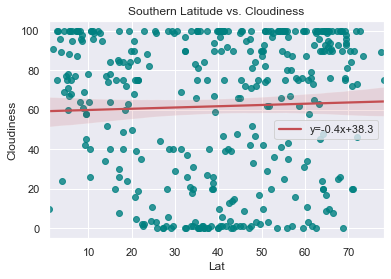

In [40]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Cloudiness'])
ax = sns.regplot(x="Lat", y="Cloudiness", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Cloudiness')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

For both north and south hemispheres there appears to little correlation between latitude and cloudiness. Regression plots for both hemispheres maintain an r-value less than 0.15, indicating little to no relationship between the two variables. This tracks as one can infer that humidity and cloudiness should be closely related. I would be interested to see if that hypothesis rings true.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

r=-0.13590240779604768, p=0.009140910773892808


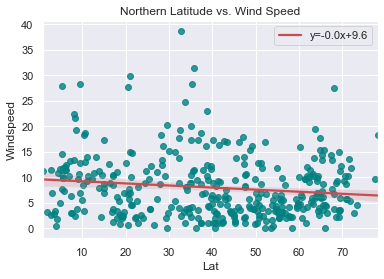

In [21]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Windspeed'])
ax = sns.regplot(x="Lat", y="Windspeed", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Wind Speed')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

r=-0.2985322308675025, p=4.250784288601865e-05


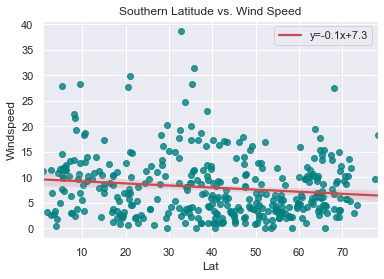

In [22]:
# Format regression plot with appropriate title, lables, and legend 
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Windspeed'])
ax = sns.regplot(x="Lat", y="Windspeed", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Wind Speed')
ax.legend()
# output r and p values
print(f'r={r_value}, p={p_value}')
plt.show()

For both north and south hemispheres there appears to little correlation between latitude and wind speed. Regression plots for both hemispheres maintain an r-value less than 0.3, indicating little to no relationship between the two variables